In [1]:
import numpy as np 
from yawisi.io import from_bts
import matplotlib.pyplot as plt
from yawisi.parameters import SimulationParameters
from yawisi.wind_field import WindField
from yawisi.display import display_points
from yawisi.spectrum import Spectrum
from yawisi.locations import Locations, Grid
# from yawisi.kernels import CoherenceKernel
from yawisi.wind import Wind
from tqdm import tqdm
import scipy.io

In [45]:
mat_data = scipy.io.loadmat('wind_sim_data_test.mat')
u = mat_data['u']  # along wind component
v = mat_data['v']  # cross-wind component
w = mat_data['w']  # vertical wind component
t = mat_data['t']  # time vector
print("Size of u:", u.shape)
print("Size of v:", v.shape)
print("Size of w:", w.shape)
print("Size of t:", t.shape)

Size of u: (400, 7201)
Size of v: (400, 7201)
Size of w: (400, 7201)
Size of t: (1, 7201)


In [4]:
mat_data_nodes = scipy.io.loadmat('wind_sim_nodes_test.mat')

# Access the elements
Y = mat_data_nodes['nodes']['Y'][0][0]  # y coordinates
Z = mat_data_nodes['nodes']['Z'][0][0]  # z coordinates
U = mat_data_nodes['nodes']['U'][0][0]  # mean wind speed

# Now you can work with the variables as needed
# For example, printing the size of each variable
print("Size of Y:", Y.shape)
print("Size of Z:", Z.shape)
print("Size of U:", U.shape)

Size of Y: (20, 20)
Size of Z: (20, 20)
Size of U: (400, 1)


In [46]:
t[0].shape

(7201,)

Text(0.5, 1.0, 'Grid Locations')

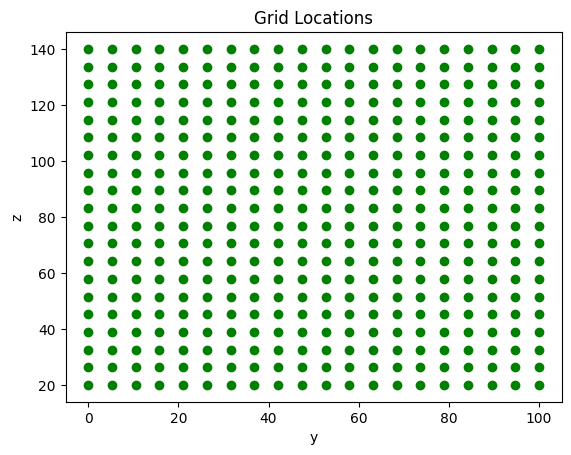

In [5]:
plt.figure()
plt.scatter(Y,Z, c='g')
plt.ylabel('z')
plt.xlabel('y')
plt.title('Grid Locations')

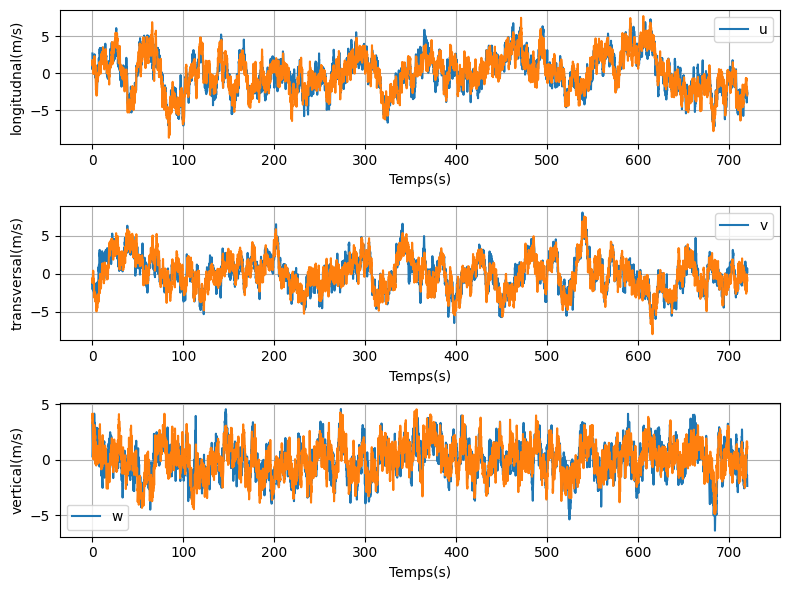

In [6]:
fig = plt.figure(figsize=(8, 6))

# Create subplots for each wind component
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
# t_tot = wind_field.params.n_samples * wind_field.params.sample_time
# Time = np.arange(0, t_tot, wind_field.params.sample_time)

# i = 0
# for i, pt in enumerate(wind_field.locations.points):
#     wind: Wind = wind_field.winds[i]

# Plot w_x in the first subplot (ax1)
ax1.plot(t[0], u[0], label="u")
ax1.plot(t[0], u[1])

# Plot w_y in the second subplot (ax2)
ax2.plot(t[0], v[0], label="v")
ax2.plot(t[0], v[1])

# Plot w_z in the third subplot (ax3)
ax3.plot(t[0], w[0], label="w")
ax3.plot(t[0], w[2])

# Set labels and title for each subplot
ax1.set_ylabel("longitudnal(m/s)")
ax1.set_xlabel("Temps(s)")
ax1.legend()
ax1.grid()

ax2.set_ylabel("transversal(m/s)")
ax2.set_xlabel("Temps(s)")
ax2.legend()
ax2.grid()

ax3.set_ylabel("vertical(m/s)")
ax3.set_xlabel("Temps(s)")
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()

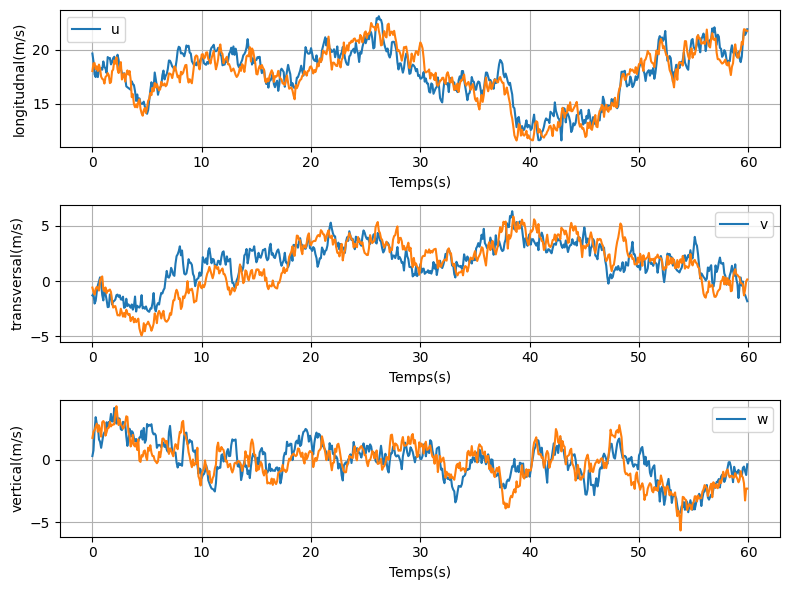

In [54]:
fig = plt.figure(figsize=(8, 6))

# Create subplots for each wind component
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)


# Plot w_x in the first subplot (ax1)
ax1.plot(t[0][:600], (u[0] + (U[0] * np.ones((u.shape[1]))))[:600] , label="u")
ax1.plot(t[0][:600], (u[1] + (U[1] * np.ones((u.shape[1]))))[:600])

# Plot w_y in the second subplot (ax2)
ax2.plot(t[0][:600], v[0][:600], label="v")
ax2.plot(t[0][:600], v[1][:600])

# Plot w_z in the third subplot (ax3)
ax3.plot(t[0][:600], w[0][:600], label="w")
ax3.plot(t[0][:600], w[1][:600])
# ax3.plot(t[0][:600], w[2][:600])

# Set labels and title for each subplot
ax1.set_ylabel("longitudnal(m/s)")
ax1.set_xlabel("Temps(s)")
ax1.legend()
ax1.grid()

ax2.set_ylabel("transversal(m/s)")
ax2.set_xlabel("Temps(s)")
ax2.legend()
ax2.grid()

ax3.set_ylabel("vertical(m/s)")
ax3.set_xlabel("Temps(s)")
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()

### Standard deviation

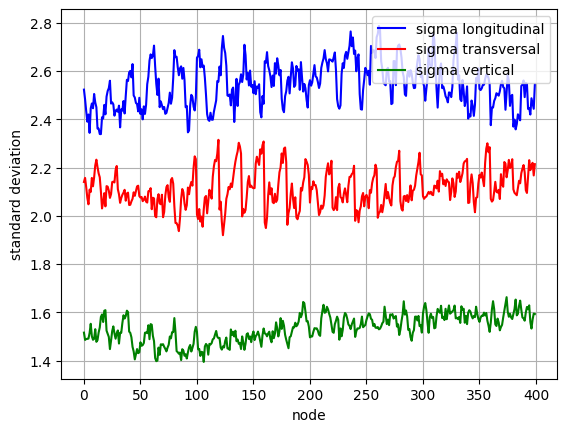

In [55]:
plt.figure()

plt.plot(np.std(u, axis=1), color='b', label='sigma longitudinal')
# plt.scatter(y, std_u, color='b')
plt.plot(np.std(v, axis=1), color='r', label='sigma transversal')
# plt.scatter(y, std_v, color='r')
plt.plot(np.std(w, axis=1), color='g', label='sigma vertical')
# plt.scatter(y, std_w, color='g')

plt.grid(True)
plt.xlabel("node")
plt.ylabel("standard deviation")
plt.legend(loc="upper right")
plt.show()

### Turbulence intensity

In [59]:
(np.std(u, axis=1)).shape

(400,)

In [8]:
u_target = U.reshape((400,))

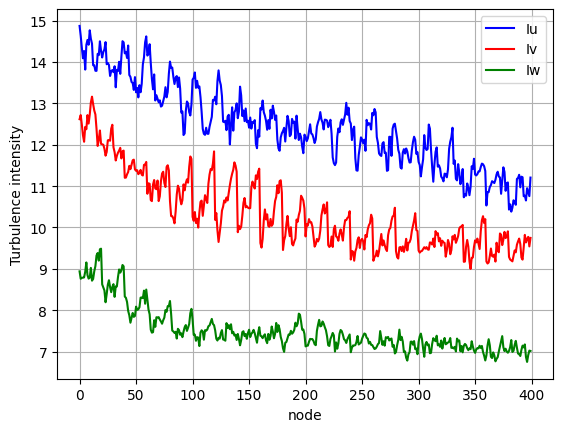

In [9]:
plt.figure()

plt.plot(np.std(u, axis=1)/ u_target *100, color='b', label='Iu')
# plt.scatter(y, std_u, color='b')
plt.plot(np.std(v, axis=1)/ u_target *100, color='r', label='Iv')
# # plt.scatter(y, std_v, color='r')
plt.plot(np.std(w, axis=1)/ u_target *100, color='g', label='Iw')
# # plt.scatter(y, std_w, color='g')

plt.grid(True)
plt.xlabel("node")
plt.ylabel("Turbulence intensity")
plt.legend(loc="upper right")
plt.show()

### Von Karman Spectrum

In [10]:
t = t[0]

In [11]:
from scipy.signal import welch
# t_tot = wind_field.params.n_samples * wind_field.params.sample_time
# Time = np.arange(0, t_tot, wind_field.params.sample_time)
Nblock = 6
tmax = t[-1]
dt = t[1] - t[0]
dt = np.median(np.diff(t))
fs = 1/dt
Nsensors, N = u.shape
Ncoh = int(round(N/Nblock))
overlap = Ncoh//2

In [12]:
Su = np.zeros((Nsensors, Ncoh//2))
for i in range(Nsensors):
    F, Spec = welch( u[i, :], fs=fs, nperseg=Ncoh, noverlap=Ncoh//2)
    Su[i, :] = Spec[1:]
Su_mean = np.mean(Su, axis=0)

In [13]:
Sv = np.zeros((Nsensors, Ncoh//2))
for i in range(Nsensors):
    F, Spec = welch( v[i, :], fs=fs, nperseg=Ncoh, noverlap=Ncoh//2)
    Sv[i, :] = Spec[1:]
Sv_mean = np.mean(Sv, axis=0)

Sw = np.zeros((Nsensors, Ncoh//2))
for i in range(Nsensors):
    F, Spec = welch( w[i, :], fs=fs, nperseg=Ncoh, noverlap=Ncoh//2)
    Sw[i, :] = Spec[1:]
Sw_mean = np.mean(Sw, axis=0)

In [14]:
coef=[-5/6, -11/6]

Lu_target = 170
Lv_target = 100
Lw_target = 35
stdU_target = 2.6
stdV_target = 2.2
stdW_target = 1.56
U_ref = 20

k = Lu_target / U_ref 
Su_target =  4*k *stdU_target**2*(1+70.7*(k*F[1:])**2)**(coef[0])

k = Lv_target / U_ref
Sv_target=  4.*k*stdV_target**2*(1+70.7*4.*(k*F[1:])**2)**(coef[1])*(1+188.4*4*(k*F[1:])**2)

k = Lw_target / U_ref
Sw_target=  4.*k*stdW_target**2*(1+70.7*4.*(k*F[1:])**2)**(coef[1])*(1+188.4*4*(k*F[1:])**2)

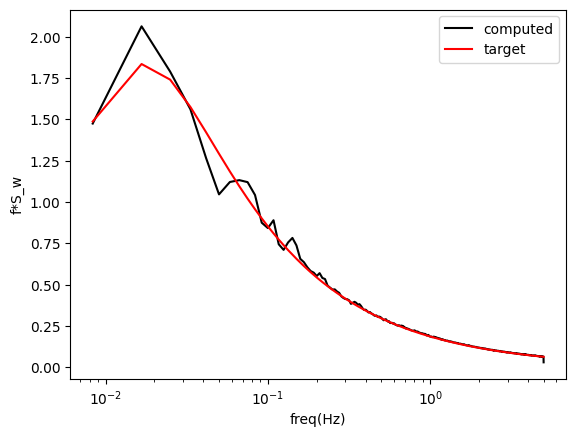

In [15]:
plt.figure()
plt.plot(F[1:], (F[1:]*Su_mean.T), color='k', label="computed")
plt.plot(F[1:], F[1:]*Su_target.T, color='r', label="target")
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_w")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

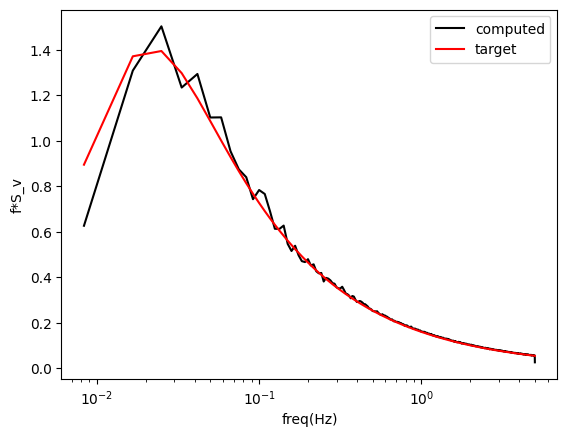

In [16]:
plt.figure()
plt.plot(F[1:], (F[1:]*Sv_mean.T), color='k', label="computed")
plt.plot(F[1:], F[1:]*Sv_target.T, color='r', label="target")
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_v")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

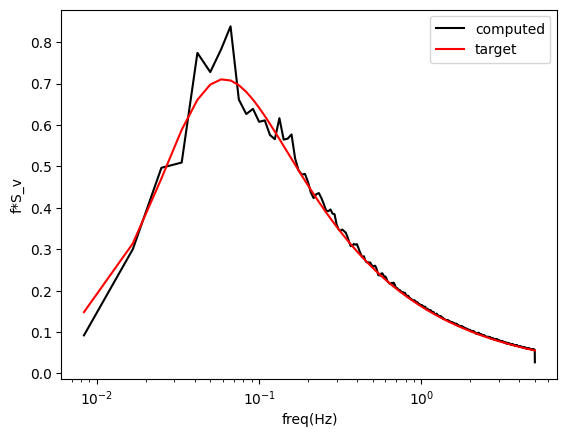

In [17]:
plt.figure()
plt.plot(F[1:], (F[1:]*Sw_mean.T), color='k', label="computed")
plt.plot(F[1:], F[1:]*Sw_target.T, color='r', label="target")
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_v")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

### Spatial coherence

In [18]:
from scipy.signal import csd

def coherence(X, Y, Fs=2, WINDOW='hann', NPERSEG=None, NOVERLAP=None, NFFT=None):

    #Get cross spectrum 
    freq, pxy = csd(X, Y, fs=Fs, window=WINDOW, nperseg=NPERSEG, noverlap=NPERSEG//2, nfft=NFFT)

    # Get single point spectrum
    _, pxx = csd(X, X, fs=Fs, window=WINDOW, nperseg=NPERSEG, noverlap=NPERSEG//2,  nfft=NFFT)
    _, pyy = csd(Y, Y, fs=Fs, window=WINDOW, nperseg=NPERSEG, noverlap=NPERSEG//2,  nfft=NFFT)

    # Normalize the cross spectrum
    cocoh = np.real(pxy / np.sqrt(pxx * pyy))  # co-coherence
    Quad = np.imag(pxy / np.sqrt(pxx * pyy))  # quad-coherence

    return cocoh, Quad, freq

In [19]:
### computed coherence matrix 
Nblock = 6
Nsensors, N = u.shape
Ncoh = round(N/Nblock)
overlap = Ncoh//2
tmax = t[-1]
dt = np.median(np.diff(t))
fs = 1/dt

cocoh = np.zeros(((Nsensors), (Nsensors), Ncoh//2))
for i in range(Nsensors):
    for j in range(Nsensors):
        coh, _, freq = coherence(u[i, :], u[j, :], Fs=fs, NPERSEG=Ncoh, NOVERLAP=overlap, NFFT=Ncoh)
        cocoh[i, j :] = coh[:Ncoh//2] 
cocoh_reshaped = np.reshape(cocoh, (Nsensors*Nsensors, -1))

In [20]:
points = []
for i in range(Y.shape[0]):
    for j in range(Z.shape[1]):
        points.append([Y[i,j], Z[i,j]])
points = np.array(points)
points.shape

(400, 2)

In [77]:
distances_matrix = np.zeros((len(points), len(points)))

# Populate the distances_matrix
for i in range(len(points)):
    for j in range(len(points)):
        point1 =points[i]
        point2 = points[j]
        distances_matrix[i, j] = np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

# Find unique rounded distance values
unique_distances = np.unique(np.round(distances_matrix.flatten(), decimals=2))
unique_distances = unique_distances.reshape(-1, 1)

### Averaging coherence over points separated by the same target distance 
meanCoCoh = np.zeros((len(unique_distances), cocoh.shape[2]))
flattened_distances = distances_matrix.flatten()
for i in range(len(unique_distances)):
    ind = np.where(np.round(flattened_distances * 100) / 100 == unique_distances[i])[0]
    if len(ind)>0:
        print(len(ind))
        meanCoCoh[i, :] = np.nanmean(cocoh_reshaped[ind], axis=0)

400
760
760
1444
720
1368
720
1368
680
1296
1292
680
1292
1224
640
1224
1216
1152
1156
640
1216
600
1140
1152
1088
1080
1088
1160
1140
1064
1020
1024
1080
1008
1020
960
952
520
988
560
960
1064
936
1008
896
952
900
884
480
912
896
864
520
988
840
832
936
840
816
884
440
836
780
832
792
768
784
480
912
748
780
864
1120
728
816
760
704
720
728
768
680
672
440
660
720
836
676
792
360
684
640
748
648
672
704
616
612
624
600
624
660
720
576
760
608
720
576
572
560
616
680
576
544
540
640
572
512
880
532
520
504
528
360
504
684
648
1040
528
476
612
576
468
448
480
520
448
240
456
484
540
432
420
320
480
608
408
504
576
432
416
544
440
384
392
468
512
640
380
360
360
480
384
396
340
432
364
728
400
532
504
336
320
476
396
160
416
304
448
352
300
336
288
360
312
420
272
384
360
280
256
392
240
456
308
432
320
288
352
120
228
408
240
364
216
324
260
384
204
360
656
224
192
264
280
240
624
280
308
560
152
208
360
288
144
312
340
136
560
168
220
252
280
288
128
192
300
256
156
400
40
76
264
252
7

4
[4]
13
[13]
44
[44]
93
[93]


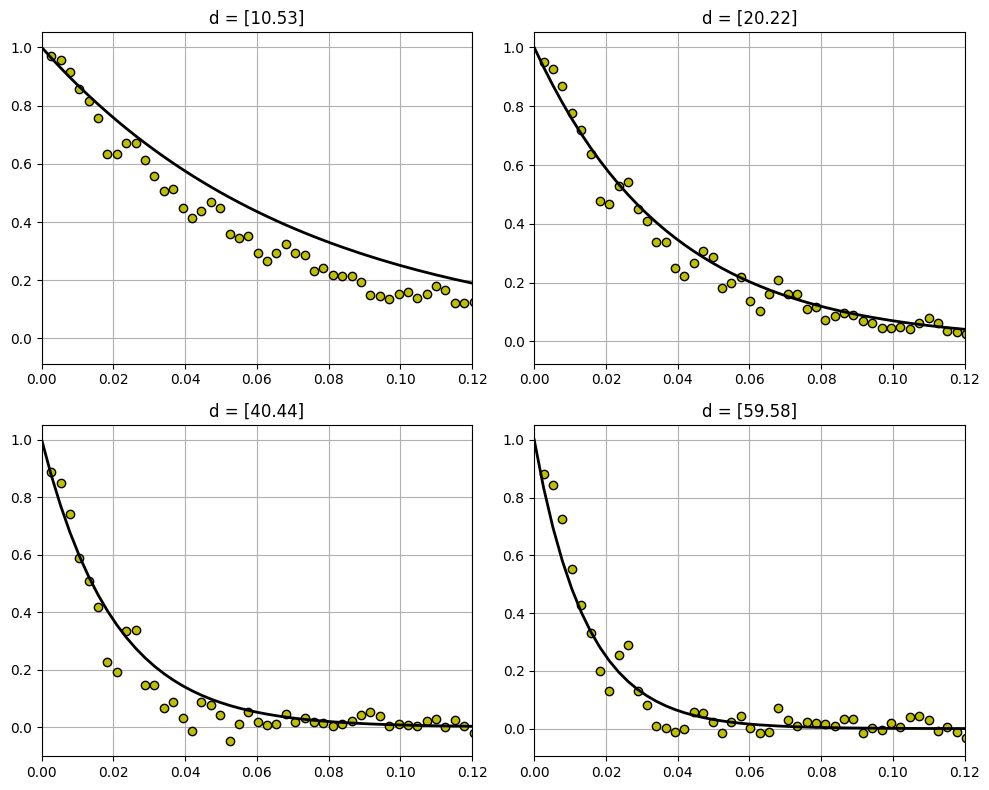

In [79]:
k = 2 * np.pi * freq / 20
distTarget = [10,20,40,60]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for ii, target in enumerate(distTarget, 1):
    # indDist = []
    ind = np.argmin(np.abs(unique_distances - target))
    print(ind)
    # indDist.append(ind)
    ax = axs[(ii - 1) // 2, (ii - 1) % 2]
    ax.plot(k[1:], meanCoCoh[ind, :].reshape((meanCoCoh.shape[1],)), 'ko', markerfacecolor='y')
    ax.plot(k[:], np.exp(-7 * unique_distances[ind] * freq / u_target[ind]), 'k', linewidth=2)
    ax.set_title(f'd = {(unique_distances[ind])}')
    ax.set_xlim([0, 0.12])
    ax.grid(True)
plt.tight_layout()
plt.show()

In [82]:
k.shape

(601,)